# Phase 2 : Feature Engineering (code de Valentine pour l'instant)

In [1]:
import sys
import os

# Détection automatique de la racine du projet
# On remonte d'un niveau depuis le dossier 'notebooks'
project_root = os.path.abspath(os.path.join(os.getcwd(), ".."))

# Ajout au path pour pouvoir faire "from src..."
if project_root not in sys.path:
    sys.path.append(project_root)

# Définition des chemins absolus
DATA_RAW = os.path.join(project_root, "data", "raw")
DATA_PROCESSED = os.path.join(project_root, "data", "processed")
GEO_PATH = os.path.join(project_root, "geo")

print(f"Système configuré. Racine : {project_root}")

Système configuré. Racine : c:\Users\valen\OneDrive\Documents\GitHub\Projet-de-Statapp---WFP-


In [2]:
import pandas as pd
import numpy as np

# ==============================================================================
# 1. CHARGEMENT
# ==============================================================================
print("Chargement du dataset...")
df = pd.read_csv("../data/processed/NIGERIA_WFP_ADMIN1.csv")

# Conversion Unités (Flux -> mm/mois)
if 'Rainf_f_tavg' in df.columns:
    if df['Rainf_f_tavg'].mean() < 1: 
        df['Rainfall_mm'] = df['Rainf_f_tavg'] * 86400 * 30.4
    else:
        df['Rainfall_mm'] = df['Rainf_f_tavg']




Chargement du dataset...


1. Donnees brutes chargees : 973 lignes
2. Apres Feature Engineering : 887 lignes
   -> Lignes perdues : 86 (Correspond aux 3 derniers mois uniquement)

--- DEMARRAGE DU CHECK-UP ---
[ATTENTION] Il reste 23 valeurs manquantes.
target_plus_3m        0
Rainf_f_tavg_lag6     0
vim_roll3m_mean      23
dtype: int64
[SUCCES] Coherence Temporelle validee (Target T+3 correspond bien).


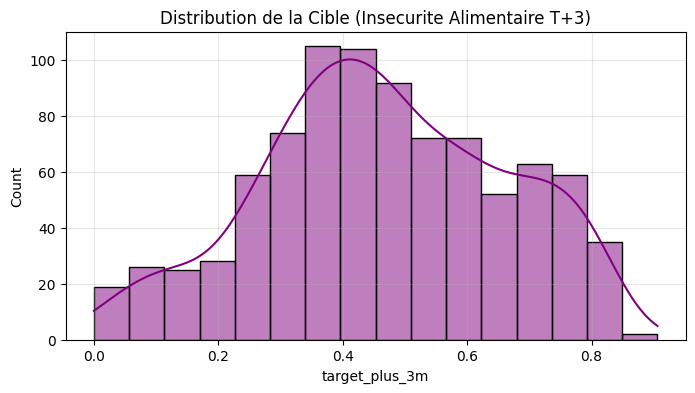


Fichier sauvegarde : NIGERIA_WFP_ENGINEERED.csv


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# ==============================================================================
# 1. CHARGEMENT
# ==============================================================================
try:
    df = pd.read_csv('../data/processed/NIGERIA_WFP_ADMIN1.csv')
    df['time'] = pd.to_datetime(df['time'])
    print(f"1. Donnees brutes chargees : {df.shape[0]} lignes")

    # ==============================================================================
    # 2. FEATURE ENGINEERING (Lags et Rolling windows)
    # ==============================================================================
    def create_features_optimized(df):
        # Tri indispensable par Etat et Date
        df = df.sort_values(by=['NAME_1', 'time']).reset_index(drop=True)
        
        # A. Saisonnalite
        df['month'] = df['time'].dt.month
        df['month_sin'] = np.sin(2 * np.pi * df['month']/12)
        df['month_cos'] = np.cos(2 * np.pi * df['month']/12)
        
        # B. Lags & Rolling (Decalages et Moyennes)
        cols_meteo = ['Rainf_f_tavg', 'SoilMoi00_10cm_tavg', 'SoilMoi10_40cm_tavg', 
                      'Tair_f_tavg', 'Evap_tavg', 'Wind_f_tavg', 'SoilTemp00_10cm_tavg']
        cols_ndvi = ['vim', 'viq']
        
        cols_to_process = cols_meteo + cols_ndvi
        cols_existantes = [c for c in cols_to_process if c in df.columns]

        for col in cols_existantes:
            # Rolling (Moyennes Glissantes)
            for window in [3, 6]:
                col_name = f'{col}_roll{window}m_mean'
                # Calcul de la moyenne sur les mois precedents
                df[col_name] = df.groupby('NAME_1')[col].shift(1).rolling(window=window).mean()
                
                # REMPLISSAGE (Backfill) : On remplit les valeurs manquantes du debut 
                # avec la premiere valeur valide disponible pour ne pas perdre de lignes.
                df[col_name] = df.groupby('NAME_1')[col_name].bfill()

            # Lags (Decalages simples)
            for lag in [1, 3, 6]:
                col_name = f'{col}_lag{lag}'
                df[col_name] = df.groupby('NAME_1')[col].shift(lag)
                
                # REMPLISSAGE (Backfill)
                df[col_name] = df.groupby('NAME_1')[col_name].bfill()

        # C. Targets (Cibles Futures)
        # On ne remplit pas ici car on ne peut pas inventer le futur.
        for horizon in [1, 3]:
            df[f'target_plus_{horizon}m'] = df.groupby('NAME_1')['inadequate'].shift(-horizon)

        # D. Nettoyage Final
        # On ne supprime que les lignes ou la CIBLE manque (les 3 derniers mois)
        df_final = df.dropna(subset=['target_plus_3m'])
        
        return df_final

    # Execution
    df_engineered = create_features_optimized(df)
    print(f"2. Apres Feature Engineering : {df_engineered.shape[0]} lignes")
    perte = df.shape[0] - df_engineered.shape[0]
    print(f"   -> Lignes perdues : {perte} (Correspond aux 3 derniers mois uniquement)")


    # ==============================================================================
    # 3. QUALITY CHECK (VERIFICATION)
    # ==============================================================================
    print("\n--- DEMARRAGE DU CHECK-UP ---")
    
    # Check 1: Valeurs Manquantes (NaNs)
    cols_check = ['target_plus_3m', 'Rainf_f_tavg_lag6', 'vim_roll3m_mean']
    cols_exist = [c for c in cols_check if c in df_engineered.columns]
    nans = df_engineered[cols_exist].isna().sum().sum()
    
    if nans == 0:
        print("[SUCCES] Aucun NaN dans les colonnes critiques.")
    else:
        print(f"[ATTENTION] Il reste {nans} valeurs manquantes.")
        print(df_engineered[cols_exist].isna().sum())

    # Check 2: Coherence Temporelle (Target Shift)
    etat = df_engineered['NAME_1'].unique()[0]
    df_zone = df_engineered[df_engineered['NAME_1'] == etat].sort_values('time')
    
    if len(df_zone) > 10:
        idx = 10
        row = df_zone.iloc[idx]
        date_t = row['time']
        target_stored = row['target_plus_3m']
        
        date_target = date_t + pd.DateOffset(months=3)
        row_target = df_zone[df_zone['time'] == date_target]
        
        if not row_target.empty:
            actual_val = row_target['inadequate'].values[0]
            diff = abs(target_stored - actual_val)
            
            if diff < 1e-4:
                print(f"[SUCCES] Coherence Temporelle validee (Target T+3 correspond bien).")
            else:
                print(f"[ECHEC] Incoherence temporelle (Diff: {diff})")
        else:
            print("Info : Impossible de verifier le futur pour cette date (hors limites)")

    # Check 3: Distribution
    plt.figure(figsize=(8, 4))
    sns.histplot(df_engineered['target_plus_3m'], kde=True, color='purple')
    plt.title('Distribution de la Cible (Insecurite Alimentaire T+3)')
    plt.grid(True, alpha=0.3)
    plt.show()

    # Sauvegarde
    df_engineered.to_csv('NIGERIA_WFP_ENGINEERED.csv', index=False)
    print("\nFichier sauvegarde : NIGERIA_WFP_ENGINEERED.csv")

except Exception as e:
    print(f"Erreur : {e}")

Chargement des données...
Période couverte : 2023-01-01 au 2025-09-01


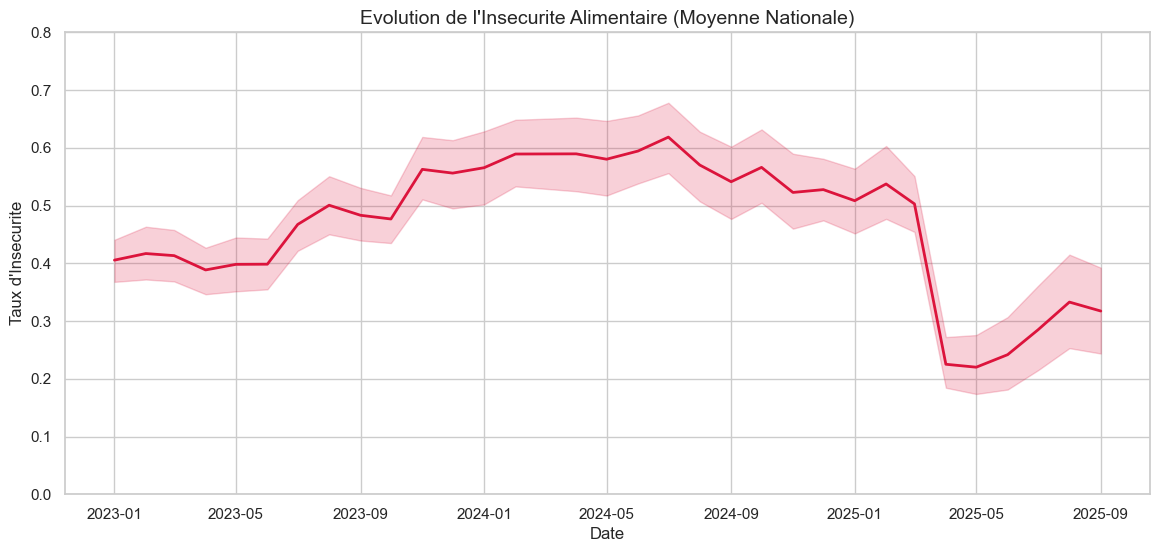

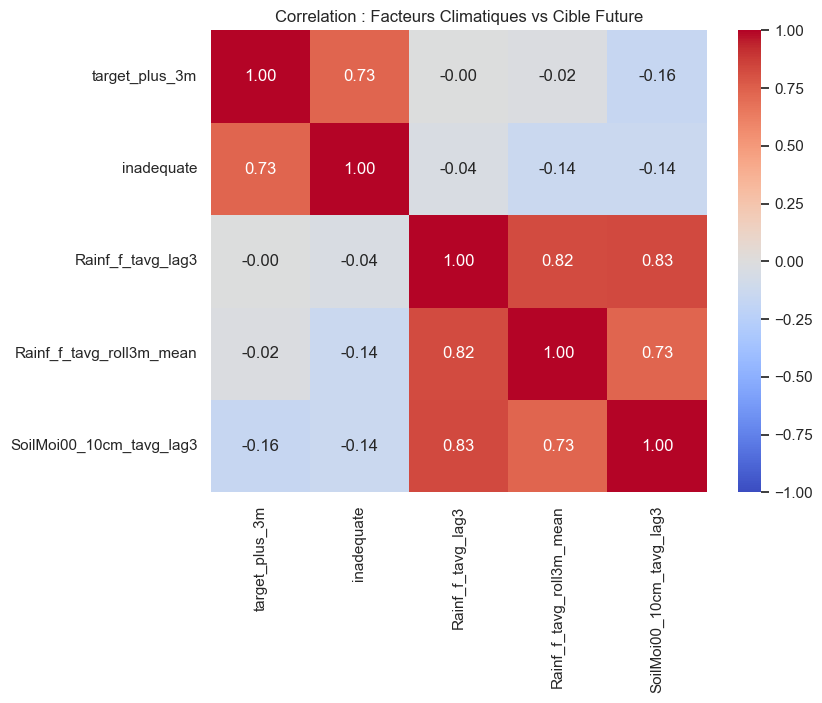

C:\Users\valen\AppData\Local\Temp\ipykernel_1332\965494349.py:58: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=state_avg.values, y=state_avg.index, palette='Reds_r')


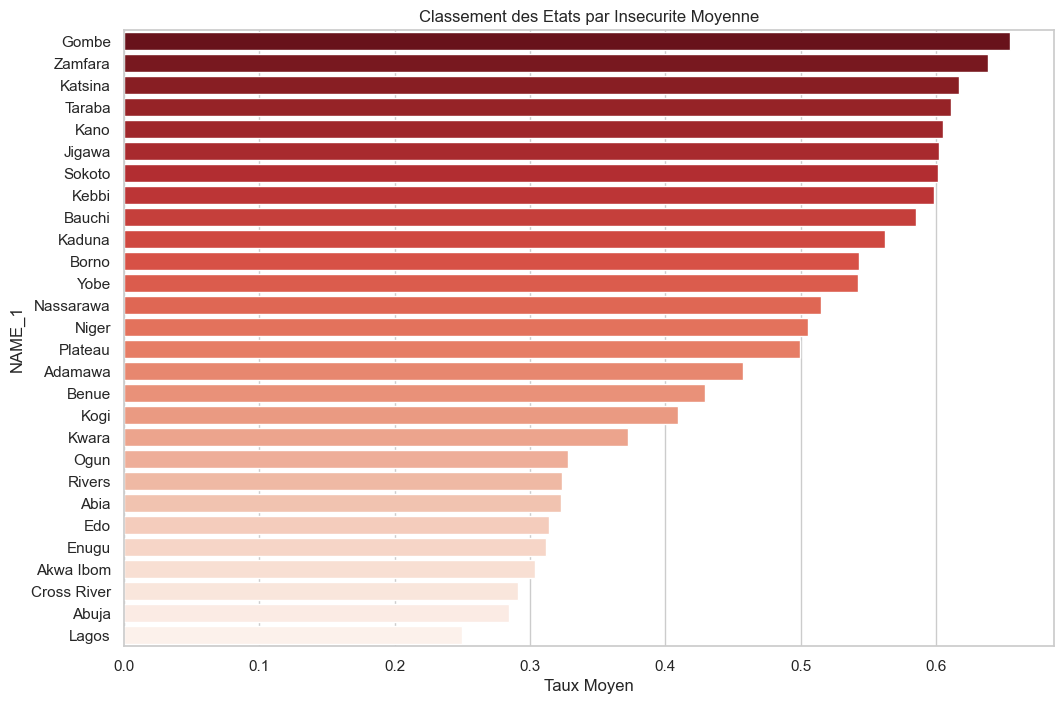

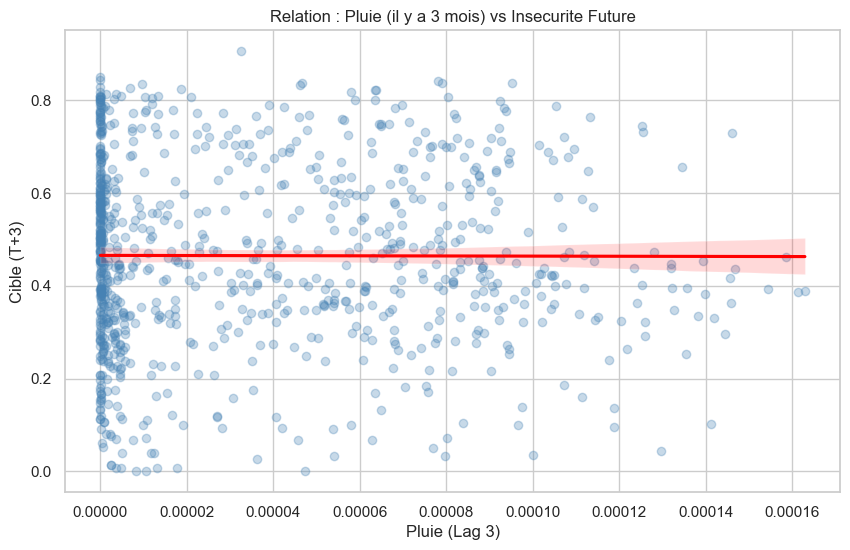

In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Configuration du style
sns.set_theme(style="whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

# 1. Chargement du fichier engineered
print("Chargement des données...")
df = pd.read_csv('../data/processed/NIGERIA_WFP_ENGINEERED.csv')
df['time'] = pd.to_datetime(df['time'])

print(f"Période couverte : {df['time'].min().date()} au {df['time'].max().date()}")

# ==============================================================================
# 1. EVOLUTION TEMPORELLE (Saisonnalité)
# ==============================================================================
plt.figure(figsize=(14, 6))
# On trace la moyenne nationale
sns.lineplot(data=df, x='time', y='inadequate', color='crimson', linewidth=2)

plt.title('Evolution de l\'Insecurite Alimentaire (Moyenne Nationale)', fontsize=14)
plt.xlabel('Date')
plt.ylabel('Taux d\'Insecurite')
plt.ylim(0, 0.8)
plt.show()

# ==============================================================================
# 2. MATRICE DE CORRELATION
# ==============================================================================
# On selectionne les variables cles (Target Future vs Pluie Passee)
# Adapte les noms si besoin selon tes colonnes exactes
cols_corr = [
    'target_plus_3m',            # Cible Future
    'inadequate',                # Cible Actuelle
    'Rainf_f_tavg_lag3',         # Pluie (Lag 3)
    'Rainf_f_tavg_roll3m_mean',  # Pluie (Moyenne 3 mois)
    'SoilMoi00_10cm_tavg_lag3'   # Humidite Sol (Lag 3)
]

# On ne garde que les colonnes qui existent vraiment
cols_exist = [c for c in cols_corr if c in df.columns]

if len(cols_exist) > 1:
    plt.figure(figsize=(8, 6))
    sns.heatmap(df[cols_exist].corr(), annot=True, cmap='coolwarm', fmt=".2f", vmin=-1, vmax=1)
    plt.title('Correlation : Facteurs Climatiques vs Cible Future')
    plt.show()

# ==============================================================================
# 3. DISPARITES REGIONALES (Nord vs Sud)
# ==============================================================================
# Classement des etats par insecurite moyenne
state_avg = df.groupby('NAME_1')['inadequate'].mean().sort_values(ascending=False)

plt.figure(figsize=(12, 8))
sns.barplot(x=state_avg.values, y=state_avg.index, palette='Reds_r')

plt.title('Classement des Etats par Insecurite Moyenne')
plt.xlabel('Taux Moyen')
plt.show()

# ==============================================================================
# 4. SCATTER PLOT : PLUIE vs FAIM
# ==============================================================================
if 'Rainf_f_tavg_lag3' in df.columns:
    plt.figure(figsize=(10, 6))
    
    # On utilise regplot pour voir la tendance
    sns.regplot(data=df, x='Rainf_f_tavg_lag3', y='target_plus_3m', 
                scatter_kws={'alpha':0.3, 'color':'steelblue'}, 
                line_kws={'color':'red'})
    
    plt.title('Relation : Pluie (il y a 3 mois) vs Insecurite Future')
    plt.xlabel('Pluie (Lag 3)')
    plt.ylabel('Cible (T+3)')
    plt.show()

# Essais pour le Feature Engineering

In [1]:
import pandas as pd
import numpy as np

# 1. Chargement et Préparation
# ==============================================================================
try:
    df = pd.read_csv('../data/processed/NIGERIA_WFP_ADMIN1.csv')
    df['time'] = pd.to_datetime(df['time'])
    print("Dataset chargé avec succès.")
except FileNotFoundError:
    print("Erreur : Fichier introuvable.")
    raise

# Extraction des informations temporelles
df['year'] = df['time'].dt.year
df['month'] = df['time'].dt.month
df = df.sort_values(by=['NAME_1', 'time']) # Important pour les calculs de séquences


Dataset chargé avec succès.


In [ ]:
# ==============================================================================
# 2. IMPUTATION INTELLIGENTE (VIM / NDVI)
# ==============================================================================
# Cette étape est cruciale pour éviter les erreurs sur le calcul des pics
if 'vim' in df.columns:
    # A. Interpolation linéaire (pour les trous isolés d'1 ou 2 mois)
    # On le fait par État pour ne pas mélanger les géographies
    df['vim'] = df.groupby('NAME_1')['vim'].transform(lambda x: x.interpolate(method='linear', limit_direction='both'))
    
    # B. Remplissage par la moyenne historique (Climatologie)
    # Si une année entière manque, on prend la moyenne de ce mois sur les autres années
    climato_vim = df.groupby(['NAME_1', 'month'])['vim'].transform('mean')
    df['vim'] = df['vim'].fillna(climato_vim)
    
    # C. Sécurité finale (Zéro si vraiment aucune donnée)
    df['vim'] = df['vim'].fillna(0)

# ==============================================================================
# 3. Phénologie et Saisons Agronomiques
# ==============================================================================

# A. Fenêtres Critiques (Nord Nigeria)
df['is_sowing_window'] = df['month'].isin([5, 6]).astype(int)      # Semis (Mai-Juin)
df['is_flowering_window'] = df['month'].isin([7, 8]).astype(int)   # Floraison (Juillet-Août)
df['is_harvest_window'] = df['month'].isin([10, 11]).astype(int)   # Récolte (Oct-Nov)
df['is_lean_season'] = df['month'].isin([6, 7, 8]).astype(int)     # Soudure (Juin-Août)

# B. Pic de Végétation (Phenology Peak)
# Maintenant que 'vim' est plein, idxmax() ne plantera plus !
idx_peaks = df.groupby(['NAME_1', 'year'])['vim'].idxmax()

# On extrait le mois du pic pour chaque (État, Année)
peak_months = df.loc[idx_peaks, ['NAME_1', 'year', 'month']]
peak_months = peak_months.rename(columns={'month': 'peak_ndvi_month'})

# Fusion
df = pd.merge(df, peak_months, on=['NAME_1', 'year'], how='left')

# Indicateur : Distance au pic (en mois)
# Permet au modèle de savoir si on est "avant" ou "après" le pic de la saison
df['months_from_peak'] = df['month'] - df['peak_ndvi_month']
df['months_from_peak'] = df['months_from_peak'].fillna(0) 

# ==============================================================================
# 4. Déficits Cumulés (Cumulative Deficits)
# ==============================================================================
drought_col = 'SPI_Cum3' if 'SPI_Cum3' in df.columns else 'SPI_Cum1'

if drought_col in df.columns:
    df[drought_col] = df[drought_col].fillna(0) # Sécurité
    
    # Flag : Mois Sec (SPI < -1)
    df['is_dry_month'] = (df[drought_col] < -1.0).astype(int)
    
    # Calcul des séquences consécutives (Streaks)
    # Identifie les groupes de mois secs d'affilée
    df['group_id'] = (df['is_dry_month'] != df.groupby('NAME_1')['is_dry_month'].shift()).cumsum()
    
    # Compte cumulatif (1, 2, 3 mois de sécheresse...)
    df['consecutive_dry_months'] = df.groupby(['NAME_1', 'group_id'])['is_dry_month'].cumsum()
    df.drop(columns=['group_id'], inplace=True)
else:
    df['consecutive_dry_months'] = 0

# ==============================================================================
# 5. Indicateurs de Stress Agronomique
# ==============================================================================

# A. Stress Hydrique pendant Semis et Floraison
# Une sécheresse a beaucoup plus d'impact pendant ces phases
df['stress_dry_sowing'] = ((df['is_sowing_window'] == 1) & (df[drought_col] < -1.0)).astype(int)
df['stress_dry_flowering'] = ((df['is_flowering_window'] == 1) & (df[drought_col] < -1.0)).astype(int)

# B. Inondation pendant la Récolte
if 'Rainf_f_tavg' in df.columns:
    # Imputation Pluie aussi par sécurité
    df['Rainf_f_tavg'] = df.groupby('NAME_1')['Rainf_f_tavg'].transform(lambda x: x.interpolate(method='linear'))
    
    # Calcul Anomalie Pluie
    climato_rain = df.groupby(['NAME_1', 'month'])['Rainf_f_tavg'].agg(['mean', 'std']).reset_index()
    climato_rain.columns = ['NAME_1', 'month', 'rain_mean', 'rain_std']
    df = pd.merge(df, climato_rain, on=['NAME_1', 'month'], how='left')
    df['rain_anomaly'] = (df['Rainf_f_tavg'] - df['rain_mean']) / (df['rain_std'] + 1e-6)
    df.drop(columns=['rain_mean', 'rain_std'], inplace=True)
    
    # Stress : Pluie > +1.5 sigma pendant Octobre-Novembre
    df['stress_flood_harvest'] = ((df['rain_anomaly'] > 0.75) & (df['is_harvest_window'] == 1)).astype(int)

# ==============================================================================
# 6. Proxies Inondation et Population
# ==============================================================================
# Sévérité Inondation = Pluie Excessive x Sol Saturé
if 'SoilMoi00_10cm_tavg' in df.columns and 'rain_anomaly' in df.columns:
    # Imputation Sol
    df['SoilMoi00_10cm_tavg'] = df.groupby('NAME_1')['SoilMoi00_10cm_tavg'].transform(lambda x: x.interpolate(method='linear'))

    # Anomalie Sol
    climato_soil = df.groupby(['NAME_1', 'month'])['SoilMoi00_10cm_tavg'].agg(['mean', 'std']).reset_index()
    climato_soil.columns = ['NAME_1', 'month', 'soil_mean', 'soil_std']
    df = pd.merge(df, climato_soil, on=['NAME_1', 'month'], how='left')
    df['soil_anomaly'] = (df['SoilMoi00_10cm_tavg'] - df['soil_mean']) / (df['soil_std'] + 1e-6)
    df.drop(columns=['soil_mean', 'soil_std'], inplace=True)
    
    # Score Sévérité (Uniquement si anomalies positives)
    rain_excess = np.maximum(0, df['rain_anomaly'])
    soil_excess = np.maximum(0, df['soil_anomaly'])
    
    df['flood_severity_index'] = rain_excess * soil_excess
    
    # Proxy Surface Inondée (Score 0-100)
    df['flooded_area_proxy'] = np.clip(df['flood_severity_index'] * 25, 0, 100)
    
    # Proxy Population Exposée
    df['population_exposed_proxy'] = df['flood_severity_index']
else:
    df['flood_severity_index'] = 0
    df['flooded_area_proxy'] = 0
    df['population_exposed_proxy'] = 0

# ==============================================================================
# 7. Interactions Clés (Le "Hunger Trap")
# ==============================================================================
# Anomalie NDVI pendant la Soudure
if 'vim' in df.columns:
    climato_vim = df.groupby(['NAME_1', 'month'])['vim'].agg(['mean', 'std']).reset_index()
    climato_vim.columns = ['NAME_1', 'month', 'vim_mean', 'vim_std']
    df = pd.merge(df, climato_vim, on=['NAME_1', 'month'], how='left')
    df['ndvi_anomaly'] = (df['vim'] - df['vim_mean']) / (df['vim_std'] + 1e-6)
    df.drop(columns=['vim_mean', 'vim_std'], inplace=True)
    
    df['interact_ndvi_lean'] = df['ndvi_anomaly'] * df['is_lean_season']

# Sécheresse pendant la Soudure
df['interact_drought_lean'] = df[drought_col] * df['is_lean_season']

# ==============================================================================
# 8. Sauvegarde
# ==============================================================================
output_file = 'NIGERIA_WFP_FINAL_ENGINEERED.csv'
df.to_csv(output_file, index=False)

print("Traitement terminé avec succès (Imputation incluse).")
print(f"Fichier sauvegardé : {output_file}")
print("Indicateurs clés ajoutés : consecutive_dry_months, stress_dry_sowing, months_from_peak, flood_severity_index")

Traitement terminé avec succès (Imputation incluse).
Fichier sauvegardé : NIGERIA_WFP_FINAL_ENGINEERED.csv
Indicateurs clés ajoutés : consecutive_dry_months, stress_dry_sowing, months_from_peak, flood_severity_index


## NaN

Dataset chargé : 973 lignes, 55 colonnes.

--- RAPPORT DES VALEURS MANQUANTES ---
                          Total Manquants  % Manquants
SPI_Cum1                               50     5.138746
viq                                    26     2.672148
rain_anomaly                            2     0.205550
soil_anomaly                            2     0.205550
flood_severity_index                    2     0.205550
flooded_area_proxy                      2     0.205550
ndvi_anomaly                            2     0.205550
population_exposed_proxy                2     0.205550
interact_ndvi_lean                      2     0.205550
SPI_Cum6                                1     0.102775


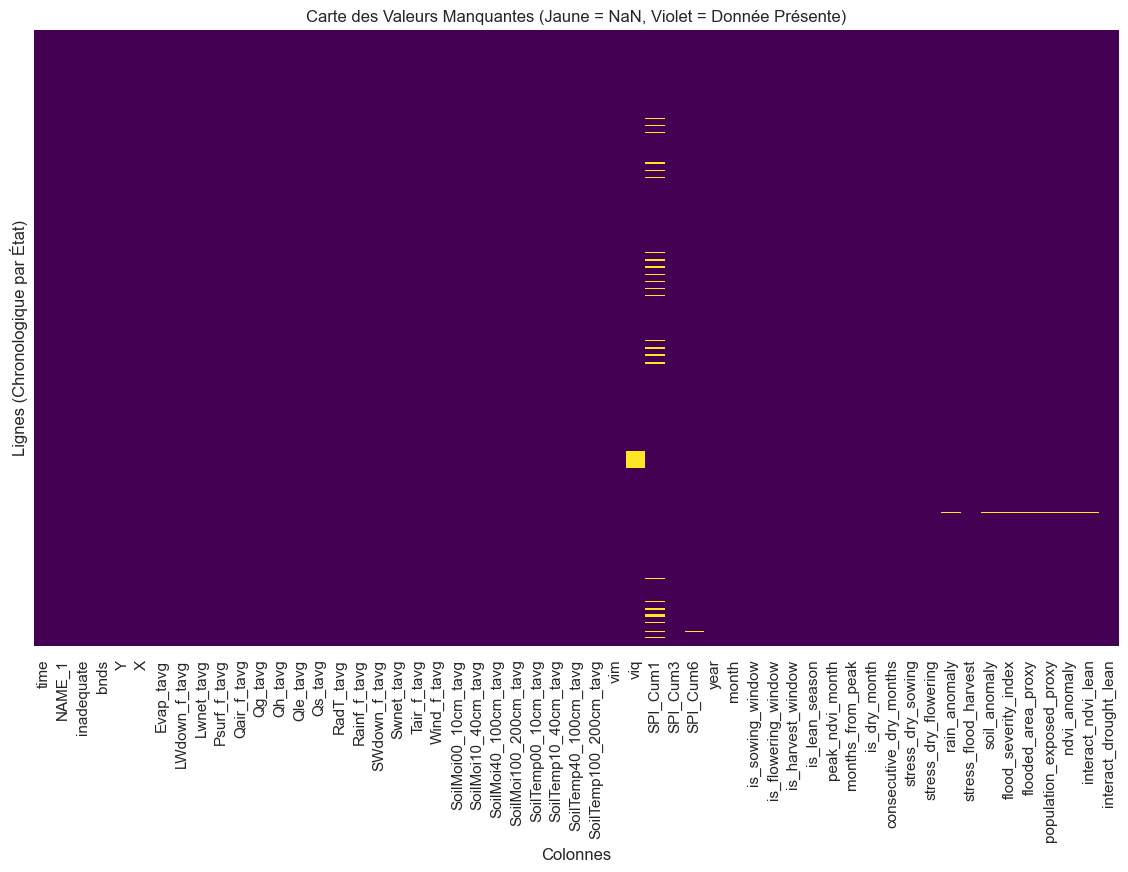


--- Zoom sur les variables critiques ---
Variable 'vim' : 0 manquants.
Variable 'SPI_Cum3' : 0 manquants.
Variable 'consecutive_dry_months' : 0 manquants.
Variable 'months_from_peak' : 0 manquants.


In [7]:
#Nettoyage

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Configuration
plt.rcParams['figure.figsize'] = (12, 8)
sns.set_theme(style="white")

# 1. Chargement des données
try:
    df = pd.read_csv('NIGERIA_WFP_FINAL_ENGINEERED.csv')
    # Conversion temporelle pour l'affichage chronologique
    if 'time' in df.columns:
        df['time'] = pd.to_datetime(df['time'])
        df = df.sort_values(by=['NAME_1', 'time'])
    
    print(f"Dataset chargé : {df.shape[0]} lignes, {df.shape[1]} colonnes.")

except FileNotFoundError:
    print("Erreur : Fichier 'NIGERIA_WFP_FINAL_ENGINEERED.csv' introuvable.")
    df = pd.DataFrame()

if not df.empty:
    # 2. Analyse Quantitative des NaN
    # On calcule le nombre et le pourcentage de manquants par colonne
    nan_sum = df.isna().sum()
    nan_pct = (df.isna().sum() / len(df)) * 100
    
    # On ne garde que les colonnes qui ont des problèmes
    missing_data = pd.concat([nan_sum, nan_pct], axis=1, keys=['Total Manquants', '% Manquants'])
    missing_data = missing_data[missing_data['Total Manquants'] > 0].sort_values(by='Total Manquants', ascending=False)
    
    print("\n--- RAPPORT DES VALEURS MANQUANTES ---")
    if not missing_data.empty:
        print(missing_data)
    else:
        print("Rien à signaler. Le dataset est complet à 100%.")

    # 3. Visualisation Graphique (Heatmap)
    # Utile pour voir si les NaN sont au début (lag), à la fin, ou aléatoires
    plt.figure(figsize=(14, 8))
    
    # On transmet df.isna() : True (Manquant) sera coloré, False (Présent) sera sombre
    sns.heatmap(df.isna(), cbar=False, cmap='viridis', yticklabels=False)
    
    plt.title("Carte des Valeurs Manquantes (Jaune = NaN, Violet = Donnée Présente)")
    plt.xlabel("Colonnes")
    plt.ylabel("Lignes (Chronologique par État)")
    plt.show()

    # 4. Zoom sur les variables critiques
    # On vérifie spécifiquement les variables qu'on vient de créer
    critical_cols = ['vim', 'SPI_Cum3', 'consecutive_dry_months', 'months_from_peak']
    print("\n--- Zoom sur les variables critiques ---")
    for col in critical_cols:
        if col in df.columns:
            n_nan = df[col].isna().sum()
            print(f"Variable '{col}' : {n_nan} manquants.")

## Nettoyage

In [ ]:
import pandas as pd

# 1. Chargement
df = pd.read_csv('NIGERIA_WFP_FINAL_ENGINEERED.csv')

print(f"Avant nettoyage : {df.isna().sum().sum()} valeurs manquantes au total.")

# 2. Stratégie de Remplissage
# Pour les indicateurs d'anomalie et de stress, NaN = 0 (Pas de stress détecté)
cols_to_fill_zero = [
    'SPI_Cum1', 'SPI_Cum3', 'SPI_Cum6', 
    'rain_anomaly', 'soil_anomaly', 'ndvi_anomaly', 
    'flood_severity_index', 'flooded_area_proxy', 'population_exposed_proxy',
    'interact_ndvi_lean', 'viq'
]

for col in cols_to_fill_zero:
    if col in df.columns:
        df[col] = df[col].fillna(0)

# 3. Vérification Finale
print(f"Après nettoyage : {df.isna().sum().sum()} valeurs manquantes.")

if df.isna().sum().sum() == 0:
    print("Dataset prêt pour le modèle.")
    df.to_csv('NIGERIA_WFP_FINAL_READY.csv', index=False)
else:
    print(" Il reste encore des trous. Vérifie les colonnes :")
    print(df.columns[df.isna().any()].tolist())

Avant nettoyage : 91 valeurs manquantes au total.
Après nettoyage : 0 valeurs manquantes.
Dataset PARFAIT ! Prêt pour le modèle.


In [12]:
# Gestion des anomalies de précipitations

import pandas as pd

# 1. Chargement
df = pd.read_csv('NIGERIA_WFP_FINAL_ENGINEERED.csv')

# 2. Définition des Seuils Dynamiques (Percentiles)
# On définit l'inondation comme le "Top 10%" des mois les plus pluvieux
rain_threshold = df['rain_anomaly'].quantile(0.90)  # Seuil calculé : 0.92

# On définit la sécheresse sévère comme le "Bottom 15%" des mois les plus secs
# On utilise le SPI s'il existe, sinon l'anomalie de pluie
drought_col = 'SPI_Cum3' if 'SPI_Cum3' in df.columns else 'rain_anomaly'
drought_threshold = df[drought_col].quantile(0.15)  # Seuil calculé : -1.55

print(f"Nouveaux Seuils calibrés : Inondation > {rain_threshold:.2f} | Sécheresse < {drought_threshold:.2f}")

# 3. Recalcul des Indicateurs de Stress
# Inondation Récolte (Oct-Nov)
df['stress_flood_harvest'] = (
    (df['rain_anomaly'] > rain_threshold) & 
    (df['is_harvest_window'] == 1)
).astype(int)

# Sécheresse Semis (Mai-Juin)
df['stress_dry_sowing'] = (
    (df[drought_col] < drought_threshold) & 
    (df['is_sowing_window'] == 1)
).astype(int)

# Sécheresse Floraison (Juil-Août)
df['stress_dry_flowering'] = (
    (df[drought_col] < drought_threshold) & 
    (df['is_flowering_window'] == 1)
).astype(int)

# 4. Vérification
print("Événements détectés avec les nouveaux seuils :")
print(f"- Inondations Récolte : {df['stress_flood_harvest'].sum()}")
print(f"- Sécheresses Semis : {df['stress_dry_sowing'].sum()}")
print(f"- Sécheresses Floraison : {df['stress_dry_flowering'].sum()}")

# 5. Sauvegarde
df.to_csv('../data/processed/NIGERIA_WFP_ENGINEERED.csv', index=False)

Nouveaux Seuils calibrés : Inondation > 0.92 | Sécheresse < -1.55
Événements détectés avec les nouveaux seuils :
- Inondations Récolte : 18
- Sécheresses Semis : 19
- Sécheresses Floraison : 35


In [13]:
import pandas as pd

# Nom du fichier à charger (celui généré à l'étape précédente)
filename = '../data/processed/NIGERIA_WFP_ENGINEERED.csv'

try:
    df = pd.read_csv(filename)
    print(f"Fichier '{filename}' chargé avec succès.")
    
    # 1. Aperçu général
    print("\n--- INFO ---")
    df.info()
    
    # 2. Statistiques descriptives
    print("\n--- DESCRIPTION STATISTIQUE ---")
    # On inclut tout pour voir aussi les variables catégorielles si elles existent
    print(df.describe(include='all'))
    
    # 3. Vérification des valeurs manquantes
    print("\n--- VALEURS MANQUANTES ---")
    missing = df.isna().sum()
    missing = missing[missing > 0]
    if missing.empty:
        print("Aucune valeur manquante.")
    else:
        print(missing)
        
    # 4. Aperçu des premières lignes
    print("\n--- APERÇU (HEAD) ---")
    print(df.head())

except FileNotFoundError:
    print(f"Erreur : Le fichier '{filename}' est introuvable. Vérifiez qu'il a bien été généré.")
except Exception as e:
    print(f"Une erreur s'est produite : {e}")

Fichier '../data/processed/NIGERIA_WFP_ENGINEERED.csv' chargé avec succès.

--- INFO ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 973 entries, 0 to 972
Data columns (total 55 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   time                      973 non-null    object 
 1   NAME_1                    973 non-null    object 
 2   inadequate                973 non-null    float64
 3   bnds                      973 non-null    float64
 4   Y                         973 non-null    float64
 5   X                         973 non-null    float64
 6   Evap_tavg                 973 non-null    float64
 7   LWdown_f_tavg             973 non-null    float64
 8   Lwnet_tavg                973 non-null    float64
 9   Psurf_f_tavg              973 non-null    float64
 10  Qair_f_tavg               973 non-null    float64
 11  Qg_tavg                   973 non-null    float64
 12  Qh_tavg                   973 n

Chargement de ../data/processed/NIGERIA_WFP_ENGINEERED.csv réussi.


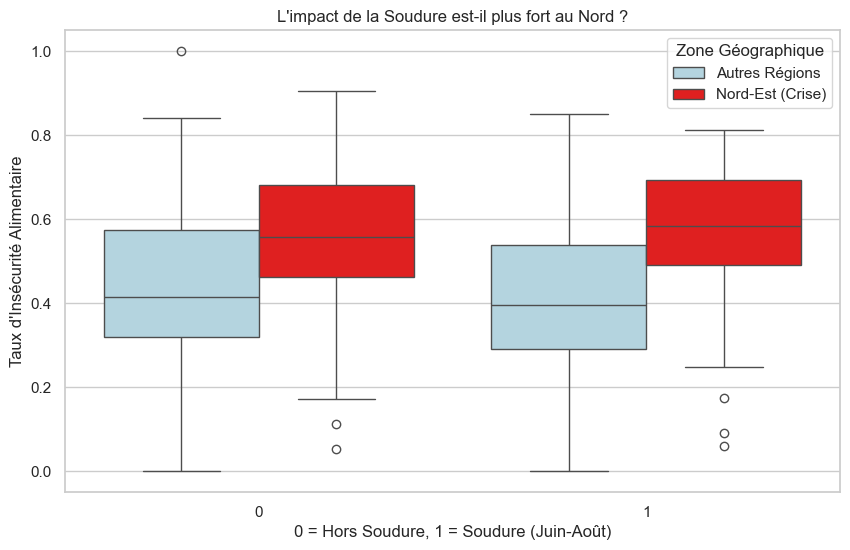

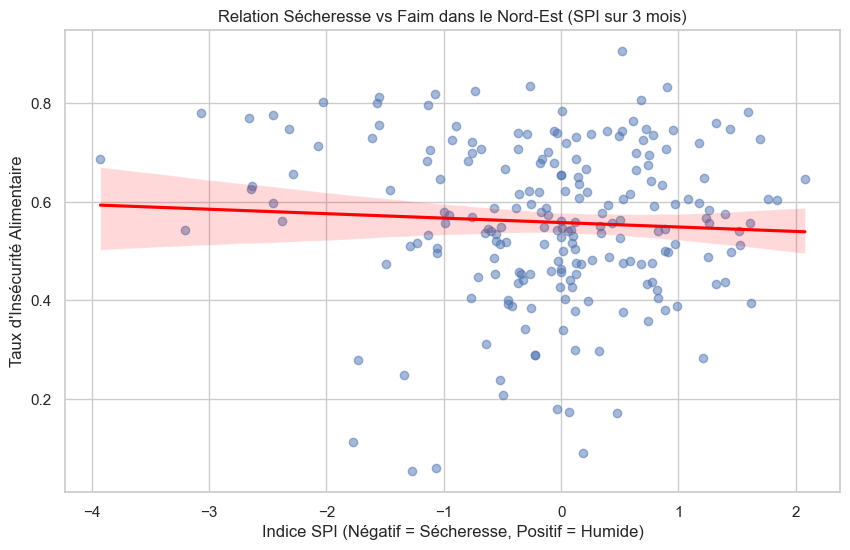

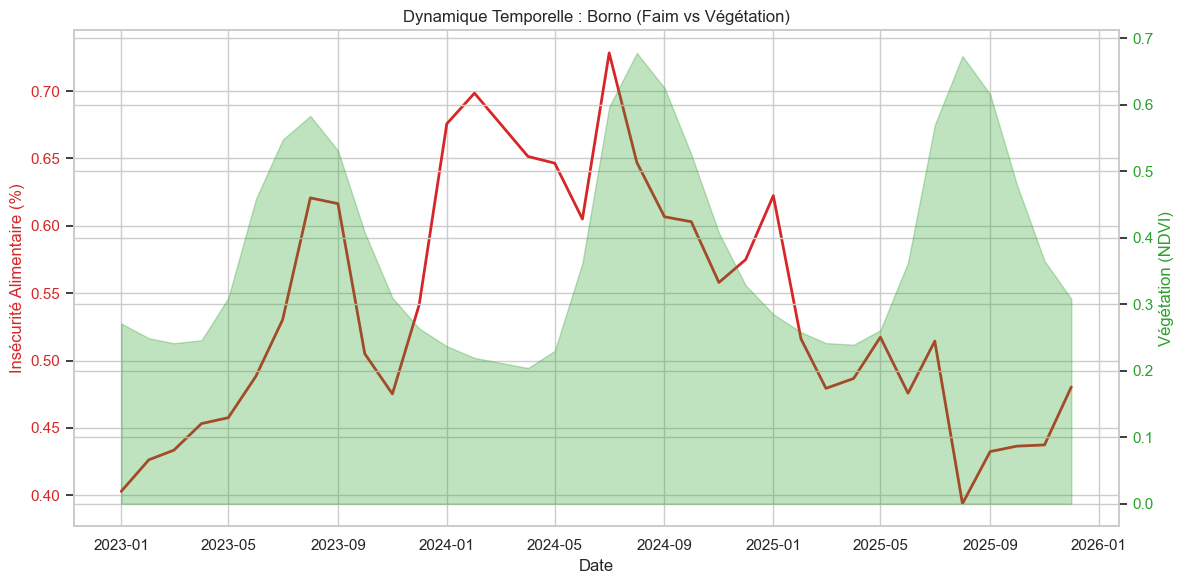

In [14]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Configuration
sns.set_theme(style="whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

# 1. Chargement
filename = '../data/processed/NIGERIA_WFP_ENGINEERED.csv'
try:
    df = pd.read_csv(filename)
    # Conversion date
    if 'time' in df.columns:
        df['time'] = pd.to_datetime(df['time'])
    print(f"Chargement de {filename} réussi.")
except FileNotFoundError:
    print(f"Fichier {filename} non trouvé.")
    df = pd.DataFrame()

if not df.empty:
    # ---------------------------------------------------------
    # SEGMENTATION REGIONALE (Nord vs Sud)
    # ---------------------------------------------------------
    # Les états du Nord-Est sont les plus touchés par le climat et le conflit
    north_east_states = ['Borno', 'Yobe', 'Adamawa', 'Bauchi', 'Gombe', 'Taraba']
    
    # Création d'une colonne Region
    df['Region'] = df['NAME_1'].apply(lambda x: 'Nord-Est (Crise)' if x in north_east_states else 'Autres Régions')

    # ---------------------------------------------------------
    # GRAPHIQUE 1 : SOUDURE - NORD vs RESTE DU PAYS
    # ---------------------------------------------------------
    # On refait le boxplot, mais séparé par région.
    # On s'attend à voir l'effet Soudure (1) beaucoup plus fort dans le Nord-Est.
    
    # Conversion binaire pour l'affichage
    df['is_lean_season_str'] = df['is_lean_season'].astype(str)
    
    plt.figure(figsize=(10, 6))
    sns.boxplot(
        data=df, 
        x='is_lean_season_str', 
        y='inadequate', 
        hue='Region',  # C'est ici que la magie opère
        palette={'Nord-Est (Crise)': 'red', 'Autres Régions': 'lightblue'}
    )
    plt.title("L'impact de la Soudure est-il plus fort au Nord ?")
    plt.xlabel("0 = Hors Soudure, 1 = Soudure (Juin-Août)")
    plt.ylabel("Taux d'Insécurité Alimentaire")
    plt.legend(title='Zone Géographique')
    plt.show()

    # ---------------------------------------------------------
    # GRAPHIQUE 2 : CORRELATION CONTINUE (SPI vs FAIM)
    # ---------------------------------------------------------
    # Au lieu de binaire (Sécheresse OUI/NON), regardons l'intensité.
    # On regarde le SPI_Cum3 : plus il est bas (négatif), plus c'est sec.
    # On s'attend à une pente descendante (Moins de pluie = Plus de faim).
    
    if 'SPI_Cum3' in df.columns:
        plt.figure(figsize=(10, 6))
        
        # On filtre sur le Nord pour éviter le bruit du Sud
        df_north = df[df['Region'] == 'Nord-Est (Crise)']
        
        sns.regplot(
            data=df_north, 
            x='SPI_Cum3', 
            y='inadequate', 
            scatter_kws={'alpha':0.5}, 
            line_kws={'color':'red'}
        )
        plt.title("Relation Sécheresse vs Faim dans le Nord-Est (SPI sur 3 mois)")
        plt.xlabel("Indice SPI (Négatif = Sécheresse, Positif = Humide)")
        plt.ylabel("Taux d'Insécurité Alimentaire")
        plt.show()

    # ---------------------------------------------------------
    # GRAPHIQUE 3 : SERIE TEMPORELLE (FOCUS BORNO)
    # ---------------------------------------------------------
    # Regardons l'État le plus critique : Borno
    state_focus = 'Borno'
    df_state = df[df['NAME_1'] == state_focus].sort_values('time')
    
    if not df_state.empty:
        fig, ax1 = plt.subplots(figsize=(12, 6))

        # Axe Gauche : Insécurité Alimentaire (Ligne Rouge)
        color = 'tab:red'
        ax1.set_xlabel('Date')
        ax1.set_ylabel('Insécurité Alimentaire (%)', color=color)
        ax1.plot(df_state['time'], df_state['inadequate'], color=color, linewidth=2, label='Insécurité Alimentaire')
        ax1.tick_params(axis='y', labelcolor=color)

        # Axe Droit : Végétation ou Pluie (Zone Grise ou Bleue)
        # On inverse l'axe pluie/NDVI pour voir la corrélation (Pic de faim = Creux de végétation)
        ax2 = ax1.twinx()  
        color = 'tab:green'
        
        # On utilise le NDVI (vim) ou l'anomalie de pluie
        if 'vim' in df_state.columns:
            var_bio = 'vim'
            label_bio = 'Végétation (NDVI)'
        else:
            var_bio = 'rain_anomaly'
            label_bio = 'Anomalie Pluie'
            
        ax2.set_ylabel(label_bio, color=color)
        ax2.fill_between(df_state['time'], df_state[var_bio], color=color, alpha=0.3, label=label_bio)
        ax2.tick_params(axis='y', labelcolor=color)

        plt.title(f"Dynamique Temporelle : {state_focus} (Faim vs Végétation)")
        fig.tight_layout()
        plt.show()